In [1]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")



In [2]:
# --- Load Data ---
df = pd.read_csv("../../dataset/processed/merged_gold_macro_final_20250331_170349.csv", parse_dates=["Date"])
df.sort_values("Date", inplace=True)
df.reset_index(drop=True, inplace=True)



In [3]:
# --- Select features for Semi-Multivariate LSTM ---
lstm_features = ["Adj_Close", "CPI", "USD_Index"]

# --- Drop missing values ---
df = df.dropna(subset=lstm_features).copy()


In [4]:
# --- Set up data for prediction ---
# Use all data up to 2024-12-31 to predict Jan 2025
cutoff_date = pd.to_datetime("2025-01-01")
df_future = df[df["Date"] < cutoff_date].copy()

# Scale using MinMaxScaler (same way as training)
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_future[lstm_features])



In [10]:
from tensorflow.keras.models import load_model

# --- Create final input sequence from the last 30 days ---
window_size = 30
target_index = 0  # 'Adj_Close'
last_sequence = df_scaled[-window_size:]  # shape (30, features)

# --- Reshape for LSTM input ---
X_input = np.expand_dims(last_sequence, axis=0)  # shape (1, 30, features)

# --- Load trained LSTM model ---
model_path = "../../models/lstm_semi_multivariate.h5"
lstm_model = load_model(model_path)

In [11]:
# --- Generate predictions for Jan 2025 (20 business days) ---
predictions = []
current_sequence = last_sequence.copy()

for _ in range(20):
    # Reshape and predict next value
    X_pred = np.expand_dims(current_sequence, axis=0)  # (1, 30, features)
    next_scaled = lstm_model.predict(X_pred)[0][0]  # scalar prediction

    # Pad into full feature array for inverse transform
    next_row = np.zeros(len(lstm_features))
    next_row[0] = next_scaled  # Only 'Adj_Close'
    next_actual = scaler.inverse_transform([next_row])[0][0]
    predictions.append(next_actual)

    # Update the sequence with predicted value + previous exog features
    last_known_features = current_sequence[-1].copy()
    new_entry = last_known_features.copy()
    new_entry[0] = next_scaled  # Update target
    current_sequence = np.vstack([current_sequence[1:], new_entry])

1/1 [==============================] - 0s 9ms/step


2025-04-05 13:32:51.851015: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 9ms/step


In [12]:
# --- Generate future dates ---
predicted_dates = pd.bdate_range(start="2025-01-01", periods=20)

# --- Create and display forecast DataFrame ---
forecast_df = pd.DataFrame({
    "Date": predicted_dates,
    "Forecast": predictions
})

print("\n📆 Forecast for January 2025 using LSTM (Semi-Multivariate):")
print(forecast_df)


📆 Forecast for January 2025 using LSTM (Semi-Multivariate):
         Date     Forecast
0  2025-01-01  2634.551001
1  2025-01-02  2638.636413
2  2025-01-03  2644.155821
3  2025-01-06  2650.560691
4  2025-01-07  2657.550967
5  2025-01-08  2664.925403
6  2025-01-09  2672.549972
7  2025-01-10  2680.345751
8  2025-01-13  2688.241687
9  2025-01-14  2696.198318
10 2025-01-15  2704.184468
11 2025-01-16  2712.176832
12 2025-01-17  2720.160081
13 2025-01-20  2728.121477
14 2025-01-21  2736.057703
15 2025-01-22  2743.954882
16 2025-01-23  2751.808870
17 2025-01-24  2759.614281
18 2025-01-27  2767.369355
19 2025-01-28  2775.076578


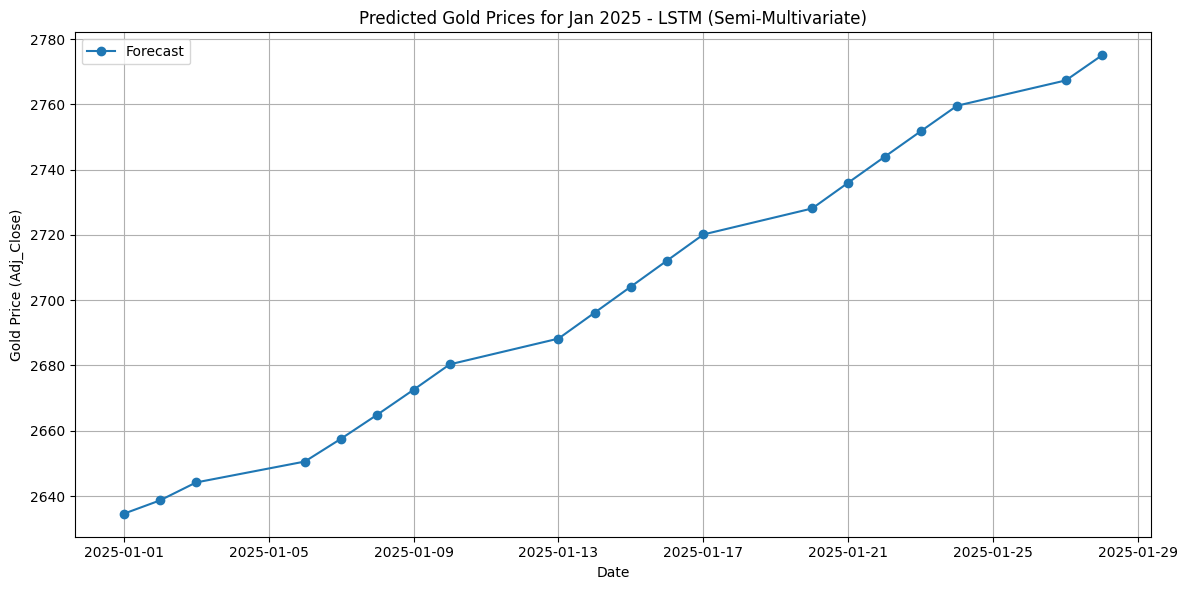

In [13]:
# --- Plot the forecast ---
plt.figure(figsize=(12, 6))
plt.plot(forecast_df["Date"], forecast_df["Forecast"], marker='o', label="Forecast")
plt.title("Predicted Gold Prices for Jan 2025 - LSTM (Semi-Multivariate)")
plt.xlabel("Date")
plt.ylabel("Gold Price (Adj_Close)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


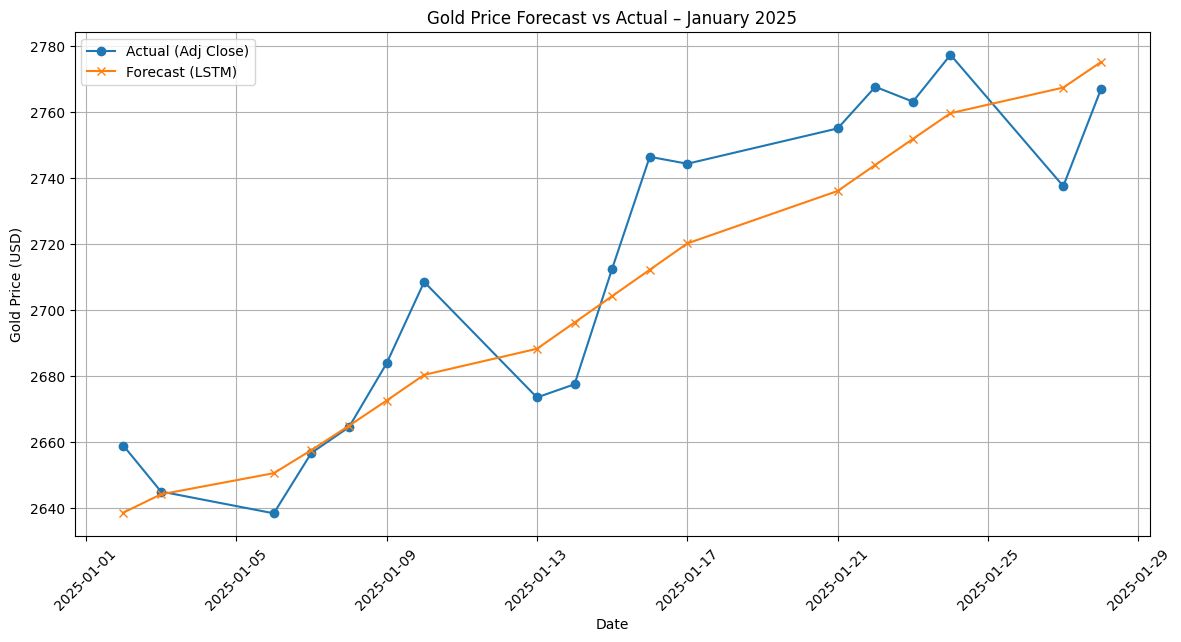

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Forecasted Values (from your model output) ---
forecast_data = {
    "Date": [
        "2025-01-01", "2025-01-02", "2025-01-03", "2025-01-06", "2025-01-07", "2025-01-08",
        "2025-01-09", "2025-01-10", "2025-01-13", "2025-01-14", "2025-01-15", "2025-01-16",
        "2025-01-17", "2025-01-20", "2025-01-21", "2025-01-22", "2025-01-23", "2025-01-24",
        "2025-01-27", "2025-01-28"
    ],
    "Forecast": [
        2634.551001, 2638.636413, 2644.155821, 2650.560691, 2657.550967, 2664.925403,
        2672.549972, 2680.345751, 2688.241687, 2696.198318, 2704.184468, 2712.176832,
        2720.160081, 2728.121477, 2736.057703, 2743.954882, 2751.808870, 2759.614281,
        2767.369355, 2775.076578
    ]
}

# --- Actual Adj Close Prices (from your screenshot) ---
actual_data = {
    "Date": [
        "2025-01-02", "2025-01-03", "2025-01-06", "2025-01-07", "2025-01-08", "2025-01-09",
        "2025-01-10", "2025-01-13", "2025-01-14", "2025-01-15", "2025-01-16", "2025-01-17",
        "2025-01-21", "2025-01-22", "2025-01-23", "2025-01-24", "2025-01-27", "2025-01-28",
        "2025-01-29", "2025-01-30"
    ],
    "Actual": [
        2658.90, 2645.00, 2638.40, 2656.70, 2664.50, 2683.80, 2708.50, 2673.50, 2677.50,
        2712.50, 2746.40, 2744.30, 2755.00, 2767.60, 2763.10, 2777.30, 2737.50, 2766.80,
        2769.10, 2823.00
    ]
}

# Convert to DataFrames
df_forecast = pd.DataFrame(forecast_data)
df_actual = pd.DataFrame(actual_data)

# Convert to datetime
df_forecast["Date"] = pd.to_datetime(df_forecast["Date"])
df_actual["Date"] = pd.to_datetime(df_actual["Date"])

# Merge on Date to align data
df_merged = pd.merge(df_forecast, df_actual, on="Date", how="inner")

# --- Plot Forecast vs Actual ---
plt.figure(figsize=(12, 6))
plt.plot(df_merged["Date"], df_merged["Actual"], label="Actual (Adj Close)", marker='o')
plt.plot(df_merged["Date"], df_merged["Forecast"], label="Forecast (LSTM)", marker='x')
plt.title("Gold Price Forecast vs Actual – January 2025")
plt.xlabel("Date")
plt.ylabel("Gold Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()
